In [1]:
import findspark

findspark.init()
import pyspark

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
from pyspark.sql.functions import col
from pyspark.sql.window import Window

In [4]:
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
MAX_MEMORY = "7g"
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 30)
spark = SparkSession.builder.appName('prediction_2_final').config("spark.executor.memory", MAX_MEMORY).config("spark.driver.memory", MAX_MEMORY).config("spark.storage.memoryFraction",1.0).getOrCreate()


In [5]:
spark.catalog.clearCache()
orders= spark.read.csv(r"D:\TN\Capstone\Datasets\orders.csv", header = True, inferSchema = True)
prior =spark.read.csv(r"D:\TN\Capstone\Datasets\order_products__prior.csv", header = True, inferSchema = True) 
train =spark.read.csv(r"D:\TN\Capstone\Datasets\order_products__train.csv", header = True, inferSchema = True) 
products = spark.read.csv(r"D:\TN\Capstone\Datasets\products.csv", header = True, inferSchema = True)
dept = spark.read.csv(r"D:\TN\Capstone\Datasets\departments.csv", header = True, inferSchema = True)
#orders.show(2)
#prior.show(2)
#train.show(2)
#products.show(2)

In [6]:
prior = prior.select('order_id','add_to_cart_order','reordered',prior.product_id.cast(StringType()).alias('product_id'))
prior = prior.where(prior['reordered']==1)
train = train.select('order_id','add_to_cart_order','reordered',train.product_id.cast(StringType()).alias('product_id'))
train = train.where(train['reordered']==1)

In [7]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

window1 = Window.partitionBy(prior['order_id'])
prior = prior.withColumn('product_count',F.max('add_to_cart_order').over(window1)).dropDuplicates()

In [8]:

orders =orders.drop('order_dow','order_hour_of_day','eval_set','cluster')
#orders.where(orders["user_id"]==1).show()

In [9]:
window_1 = Window.partitionBy(orders['user_id']).orderBy(orders['order_number'].desc())
window_2 = Window.partitionBy(orders['user_id'])
window_3 = window_1.rangeBetween(Window.unboundedPreceding, 0)
orders = orders.withColumn('days_since_prior_order_running_total',F.sum('days_since_prior_order').over(window_3))
#orders.where(orders["user_id"]==1).show()
#orders.show(2)


In [10]:

orders_prior_df = prior.join(orders, on = 'order_id', how = 'inner')
#orders_prior_df = orders_prior_df.where(orders_prior_df["reordered"]=1)
#orders_prior_df.show(2)
orders_train_df = train.join(orders, on = 'order_id', how = 'inner')
#orders_train_df.show(2)

In [11]:
orders_prior_df.dtypes
orders_train_df.dtypes

[('order_id', 'int'),
 ('add_to_cart_order', 'int'),
 ('reordered', 'int'),
 ('product_id', 'string'),
 ('user_id', 'int'),
 ('order_number', 'int'),
 ('days_since_prior_order', 'double'),
 ('days_since_prior_order_running_total', 'double')]

User_product features

In [12]:
column_list = ["user_id","product_id"]
window = Window.partitionBy([col(x) for x in column_list])
window_2 = Window.partitionBy([col(x) for x in column_list]).orderBy(orders_prior_df['order_number'].desc())
window_4= Window.partitionBy('user_id')
order_latest60 = orders_prior_df.where(col('days_since_prior_order_running_total')<=60)
order_latest60 = order_latest60.withColumn('userprod_order_count_60', F.count('order_id').over(window))
order_latest60 = order_latest60.withColumn('user_orders_in60', F.count('order_id').over(window_4))
order_latest60 = order_latest60.withColumn('user_days_since_prior_order', F.min('days_since_prior_order_running_total').over(window_4))
order_latest60 = order_latest60.withColumn('userprod_in60_reorder_rate', order_latest60 ['userprod_order_count_60']/order_latest60['user_orders_in60'])
order_latest60 = order_latest60.withColumn('avg_prod_count', F.round(F.avg("product_count").over(window_4)))

In [13]:
order_latest60.dtypes

[('order_id', 'int'),
 ('add_to_cart_order', 'int'),
 ('reordered', 'int'),
 ('product_id', 'string'),
 ('product_count', 'int'),
 ('user_id', 'int'),
 ('order_number', 'int'),
 ('days_since_prior_order', 'double'),
 ('days_since_prior_order_running_total', 'double'),
 ('userprod_order_count_60', 'bigint'),
 ('user_orders_in60', 'bigint'),
 ('user_days_since_prior_order', 'double'),
 ('userprod_in60_reorder_rate', 'double'),
 ('avg_prod_count', 'double')]

In [14]:
#order_latest60.select('order_id','user_id','product_id','userprod_order_count_60','userprod_in60_reorder_rate').dropDuplicates().orderBy('user_id').show(50)

In [15]:
order_latest60=order_latest60.select('order_id','user_id','product_id', 'order_number','user_days_since_prior_order','days_since_prior_order_running_total',F.round(F.avg('days_since_prior_order').over(window)).alias('user_prod_purchase_frequency'),F.round(F.avg('add_to_cart_order').over(window)).alias('avg_add_to_cart_order'),'userprod_order_count_60','userprod_in60_reorder_rate','avg_prod_count').orderBy(orders_prior_df['user_id']).dropDuplicates()

In [16]:
#order_latest60.show()

In [17]:
orders_train_df = orders_train_df.select('user_id','product_id','days_since_prior_order').dropDuplicates()

In [18]:
from pyspark.sql.types import StringType
# Converting label days_since_prior_order to categorical column
def purchase_interval(r):
    if r <= 15:
        return "Class0"
    elif r > 15:
        return "Class1"


ol_val = udf(purchase_interval, StringType())

orders_train_df = orders_train_df.withColumn("predicted_purchase_interval",F.lit(ol_val(orders_train_df.days_since_prior_order)))



In [19]:
#orders_train_df.orderBy('user_id').show()

In [20]:
#print(orders_train_df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in orders_train_df.columns]).toPandas().transpose())

In [21]:
train_users = orders_train_df.select('user_id')

In [22]:
#train_users.show()

In [23]:
x_df = order_latest60.join(train_users, on = 'user_id', how='inner')

In [24]:
x_df = x_df.dropDuplicates()

In [25]:

train_user_prod_df=orders_train_df.withColumn("list_of_products_in_latest_order", F.concat_ws(",", "product_id")).select("user_id", "days_since_prior_order","list_of_products_in_latest_order").groupBy("user_id").agg(F.collect_list("list_of_products_in_latest_order").alias("latest_ordered_products"))
train_user_prod_df_1 = orders_train_df.join(train_user_prod_df, on ='user_id', how = 'inner')
train_user_prod_df_2 = train_user_prod_df_1.select("user_id","latest_ordered_products","predicted_purchase_interval")


In [26]:
x_df=x_df.join(train_user_prod_df_2, on = 'user_id',how='inner')


In [27]:
from pyspark.sql.types import IntegerType

def in_cart(product_id,latest_ordered_products):
   # Check for the case where there is no Array, otherwise we will get an Error
   if latest_ordered_products == None:
      return None
   # Checking each and every Array element if it exists in 'FullAddress',
   # and if a match is found, it's immediately returned.
   for x in latest_ordered_products:
      if x in product_id:
         return 1
   return 0
simpleudf = udf(in_cart, IntegerType())
x_df=x_df.withColumn("is_in_next_cart",simpleudf(col('product_id'),col('latest_ordered_products')))


In [28]:
x_df = x_df.dropDuplicates()

In [29]:
#x_df.orderBy('user_id').show()

In [30]:
from pyspark.sql.functions import dense_rank,col
window_1 = Window.partitionBy(x_df['user_id']).orderBy(x_df['order_number'].desc())
window_2 = Window.partitionBy([col(x) for x in column_list]).orderBy(x_df['order_number'].desc())
x_df= x_df.withColumn('rank',dense_rank().over(window_1))
x_df = x_df.withColumn("recency_userproduct", F.min("days_since_prior_order_running_total").over(window_2))


In [31]:
order_prod_list = orders_prior_df.withColumn("products", F.concat_ws(",", "product_id")).select("order_id","user_id", "order_number",'products').groupBy("order_id").agg(F.collect_list("products").alias("products"))
#order_prod_list.show(5)

In [32]:
x_df = x_df.join(order_prod_list, on = 'order_id', how = 'inner')


In [33]:
#user_prod_latest4_df.show()

In [34]:
latest_prod = x_df.select("user_id","products").where(x_df["rank"] == 1).dropDuplicates()
latest_prod = latest_prod.withColumnRenamed("products","latest1_products")
latest1_prod = x_df.select("user_id","products").where(x_df["rank"] == 2).dropDuplicates()
latest1_prod = latest1_prod.withColumnRenamed("products","latest2_products")


In [35]:
latest2_prod = x_df.select("user_id","products").where(x_df["rank"] == 3).dropDuplicates()
latest2_prod = latest2_prod.withColumnRenamed("products","latest3_products")

In [36]:
x_df = x_df.join(latest_prod, on = 'user_id', how = 'inner')
x_df = x_df.join(latest1_prod, on = 'user_id', how = 'inner')

#x_df.show(2)


In [37]:
x_df = x_df.join(latest2_prod, on = 'user_id', how = 'inner')

In [38]:
x_df=x_df.withColumn("is_in_latest1_order",simpleudf(col('product_id'),col('latest1_products')))
x_df.dtypes

[('user_id', 'int'),
 ('order_id', 'int'),
 ('product_id', 'string'),
 ('order_number', 'int'),
 ('user_days_since_prior_order', 'double'),
 ('days_since_prior_order_running_total', 'double'),
 ('user_prod_purchase_frequency', 'double'),
 ('avg_add_to_cart_order', 'double'),
 ('userprod_order_count_60', 'bigint'),
 ('userprod_in60_reorder_rate', 'double'),
 ('avg_prod_count', 'double'),
 ('latest_ordered_products', 'array<string>'),
 ('predicted_purchase_interval', 'string'),
 ('is_in_next_cart', 'int'),
 ('rank', 'int'),
 ('recency_userproduct', 'double'),
 ('products', 'array<string>'),
 ('latest1_products', 'array<string>'),
 ('latest2_products', 'array<string>'),
 ('latest3_products', 'array<string>'),
 ('is_in_latest1_order', 'int')]

In [39]:
#x_df.show(2)

In [40]:
x_df=x_df.withColumn("is_in_latest2_order",simpleudf(col('product_id'),col('latest2_products')))
x_df.dtypes


[('user_id', 'int'),
 ('order_id', 'int'),
 ('product_id', 'string'),
 ('order_number', 'int'),
 ('user_days_since_prior_order', 'double'),
 ('days_since_prior_order_running_total', 'double'),
 ('user_prod_purchase_frequency', 'double'),
 ('avg_add_to_cart_order', 'double'),
 ('userprod_order_count_60', 'bigint'),
 ('userprod_in60_reorder_rate', 'double'),
 ('avg_prod_count', 'double'),
 ('latest_ordered_products', 'array<string>'),
 ('predicted_purchase_interval', 'string'),
 ('is_in_next_cart', 'int'),
 ('rank', 'int'),
 ('recency_userproduct', 'double'),
 ('products', 'array<string>'),
 ('latest1_products', 'array<string>'),
 ('latest2_products', 'array<string>'),
 ('latest3_products', 'array<string>'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int')]

In [41]:
x_df=x_df.withColumn("is_in_latest3_order",simpleudf(col('product_id'),col('latest3_products')))
x_df.dtypes

[('user_id', 'int'),
 ('order_id', 'int'),
 ('product_id', 'string'),
 ('order_number', 'int'),
 ('user_days_since_prior_order', 'double'),
 ('days_since_prior_order_running_total', 'double'),
 ('user_prod_purchase_frequency', 'double'),
 ('avg_add_to_cart_order', 'double'),
 ('userprod_order_count_60', 'bigint'),
 ('userprod_in60_reorder_rate', 'double'),
 ('avg_prod_count', 'double'),
 ('latest_ordered_products', 'array<string>'),
 ('predicted_purchase_interval', 'string'),
 ('is_in_next_cart', 'int'),
 ('rank', 'int'),
 ('recency_userproduct', 'double'),
 ('products', 'array<string>'),
 ('latest1_products', 'array<string>'),
 ('latest2_products', 'array<string>'),
 ('latest3_products', 'array<string>'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('is_in_latest3_order', 'int')]

#x_df.cache()

x_df.orderBy(['user_id','product_id'],ascending = True).show()

In [42]:
x_df=x_df.drop('latest1_products','latest2_products','latest3_products','latest_ordered_products','rank','products','order_number','order_id','days_since_prior_order_running_total').dropDuplicates()
x_df.dtypes


[('user_id', 'int'),
 ('product_id', 'string'),
 ('user_days_since_prior_order', 'double'),
 ('user_prod_purchase_frequency', 'double'),
 ('avg_add_to_cart_order', 'double'),
 ('userprod_order_count_60', 'bigint'),
 ('userprod_in60_reorder_rate', 'double'),
 ('avg_prod_count', 'double'),
 ('predicted_purchase_interval', 'string'),
 ('is_in_next_cart', 'int'),
 ('recency_userproduct', 'double'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('is_in_latest3_order', 'int')]

In [43]:
x_df=x_df.withColumn("productid", x_df.product_id.cast("int"))


In [44]:
x_df.dtypes

[('user_id', 'int'),
 ('product_id', 'string'),
 ('user_days_since_prior_order', 'double'),
 ('user_prod_purchase_frequency', 'double'),
 ('avg_add_to_cart_order', 'double'),
 ('userprod_order_count_60', 'bigint'),
 ('userprod_in60_reorder_rate', 'double'),
 ('avg_prod_count', 'double'),
 ('predicted_purchase_interval', 'string'),
 ('is_in_next_cart', 'int'),
 ('recency_userproduct', 'double'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('is_in_latest3_order', 'int'),
 ('productid', 'int')]

In [45]:
x_df = x_df.drop('product_id')
x_df = x_df.withColumnRenamed("productid","product_id")
x_df.dtypes

[('user_id', 'int'),
 ('user_days_since_prior_order', 'double'),
 ('user_prod_purchase_frequency', 'double'),
 ('avg_add_to_cart_order', 'double'),
 ('userprod_order_count_60', 'bigint'),
 ('userprod_in60_reorder_rate', 'double'),
 ('avg_prod_count', 'double'),
 ('predicted_purchase_interval', 'string'),
 ('is_in_next_cart', 'int'),
 ('recency_userproduct', 'double'),
 ('is_in_latest1_order', 'int'),
 ('is_in_latest2_order', 'int'),
 ('is_in_latest3_order', 'int'),
 ('product_id', 'int')]

In [46]:
x_df.cache()

DataFrame[user_id: int, user_days_since_prior_order: double, user_prod_purchase_frequency: double, avg_add_to_cart_order: double, userprod_order_count_60: bigint, userprod_in60_reorder_rate: double, avg_prod_count: double, predicted_purchase_interval: string, is_in_next_cart: int, recency_userproduct: double, is_in_latest1_order: int, is_in_latest2_order: int, is_in_latest3_order: int, product_id: int]

In [47]:
#print(x_df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in x_df.columns]).toPandas().transpose())
#x_df = x_df.na.fill(999)
print(x_df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in x_df.columns]).toPandas().transpose())

                              0
user_id                       0
user_days_since_prior_order   0
user_prod_purchase_frequency  0
avg_add_to_cart_order         0
userprod_order_count_60       0
userprod_in60_reorder_rate    0
avg_prod_count                0
predicted_purchase_interval   0
is_in_next_cart               0
recency_userproduct           0
is_in_latest1_order           0
is_in_latest2_order           0
is_in_latest3_order           0
product_id                    0


In [48]:
df_p = x_df.toPandas()

In [49]:
df_p.to_csv("user_prod_data.csv")

In [50]:
df_p.shape

(1209131, 14)

In [51]:
df_p.keys()

Index(['user_id', 'user_days_since_prior_order', 'user_prod_purchase_frequency', 'avg_add_to_cart_order', 'userprod_order_count_60', 'userprod_in60_reorder_rate', 'avg_prod_count', 'predicted_purchase_interval', 'is_in_next_cart', 'recency_userproduct', 'is_in_latest1_order', 'is_in_latest2_order', 'is_in_latest3_order', 'product_id'], dtype='object')

In [52]:
df_p.describe()

,user_id,user_days_since_prior_order,user_prod_purchase_frequency,avg_add_to_cart_order,userprod_order_count_60,userprod_in60_reorder_rate,avg_prod_count,is_in_next_cart,recency_userproduct,is_in_latest1_order,is_in_latest2_order,is_in_latest3_order,product_id
count,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06
mean,1.025426e+05,1.634347e+01,8.010228e+00,8.807827e+00,2.027368e+00,4.327571e-02,1.509498e+01,2.437982e-01,2.927936e+01,3.423045e-01,3.347073e-01,3.232594e-01,2.565433e+04
std,5.953408e+04,9.578907e+00,5.283646e+00,6.776144e+00,1.734785e+00,5.059348e-02,7.836154e+00,4.293726e-01,1.496162e+01,4.744811e-01,4.718882e-01,4.677210e-01,1.413186e+04
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,5.561735e-04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,5.114100e+04,9.000000e+00,5.000000e+00,4.000000e+00,1.000000e+00,1.515152e-02,9.000000e+00,0.000000e+00,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.351700e+04
50%,1.019200e+05,1.400000e+01,7.000000e+00,7.000000e+00,1.000000e+00,2.857143e-02,1.400000e+01,0.000000e+00,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.551300e+04
75%,1.541790e+05,2.100000e+01,1.000000e+01,1.200000e+01,2.000000e+00,5.263158e-02,1.900000e+01,0.000000e+00,4.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.824100e+04
max,2.062000e+05,6.000000e+01,3.000000e+01,9.900000e+01,8.000000e+01,1.000000e+00,7.800000e+01,1.000000e+00,6.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,4.968800e+04


In [53]:
data = df_p

In [54]:
data.columns.tolist()

['user_id',
 'user_days_since_prior_order',
 'user_prod_purchase_frequency',
 'avg_add_to_cart_order',
 'userprod_order_count_60',
 'userprod_in60_reorder_rate',
 'avg_prod_count',
 'predicted_purchase_interval',
 'is_in_next_cart',
 'recency_userproduct',
 'is_in_latest1_order',
 'is_in_latest2_order',
 'is_in_latest3_order',
 'product_id']

In [55]:
cols = ['user_id',
 'product_id',
 'user_days_since_prior_order',
 'user_prod_purchase_frequency',
 'avg_add_to_cart_order',
 'userprod_order_count_60',
 'userprod_in60_reorder_rate',
 'avg_prod_count',
 'predicted_purchase_interval',
 'recency_userproduct',
 'is_in_latest1_order',
 'is_in_latest2_order',
 'is_in_latest3_order',
 'is_in_next_cart'
 ]

In [119]:
data_1 = data[cols]

In [120]:
#data_1 = data_1.drop(['user_days_since_prior_order'],axis=1)
# label encoding the data 
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 
  
data_1['predicted_purchase_interval']= le.fit_transform(data_1['predicted_purchase_interval']) 

In [121]:
data_1.describe()

,user_id,product_id,user_days_since_prior_order,user_prod_purchase_frequency,avg_add_to_cart_order,userprod_order_count_60,userprod_in60_reorder_rate,avg_prod_count,predicted_purchase_interval,recency_userproduct,is_in_latest1_order,is_in_latest2_order,is_in_latest3_order,is_in_next_cart
count,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06,1.209131e+06
mean,1.025426e+05,2.565433e+04,1.634347e+01,8.010228e+00,8.807827e+00,2.027368e+00,4.327571e-02,1.509498e+01,1.193990e-01,2.927936e+01,3.423045e-01,3.347073e-01,3.232594e-01,2.437982e-01
std,5.953408e+04,1.413186e+04,9.578907e+00,5.283646e+00,6.776144e+00,1.734785e+00,5.059348e-02,7.836154e+00,3.242575e-01,1.496162e+01,4.744811e-01,4.718882e-01,4.677210e-01,4.293726e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,5.561735e-04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.114100e+04,1.351700e+04,9.000000e+00,5.000000e+00,4.000000e+00,1.000000e+00,1.515152e-02,9.000000e+00,0.000000e+00,1.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.019200e+05,2.551300e+04,1.400000e+01,7.000000e+00,7.000000e+00,1.000000e+00,2.857143e-02,1.400000e+01,0.000000e+00,2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.541790e+05,3.824100e+04,2.100000e+01,1.000000e+01,1.200000e+01,2.000000e+00,5.263158e-02,1.900000e+01,0.000000e+00,4.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,2.062000e+05,4.968800e+04,6.000000e+01,3.000000e+01,9.900000e+01,8.000000e+01,1.000000e+00,7.800000e+01,1.000000e+00,6.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [122]:
len(data_1.keys())

14

In [123]:
data_1.keys()

Index(['user_id', 'product_id', 'user_days_since_prior_order', 'user_prod_purchase_frequency', 'avg_add_to_cart_order', 'userprod_order_count_60', 'userprod_in60_reorder_rate', 'avg_prod_count', 'predicted_purchase_interval', 'recency_userproduct', 'is_in_latest1_order', 'is_in_latest2_order', 'is_in_latest3_order', 'is_in_next_cart'], dtype='object')

In [124]:
from sklearn.model_selection import GroupShuffleSplit
train_ind, test_ind = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(data_1, groups=data_1['user_id']))

train = data_1.iloc[train_ind]
test = data_1.iloc[test_ind]

In [125]:
array = data_1.values
X = array[:,2:13]
Y = array[:,13]

In [126]:
Y

array([0., 0., 0., ..., 0., 1., 0.])

In [127]:
from collections import Counter
counter = Counter(Y)
print(counter[0])
print(counter[1])
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

914347
294784
Estimate: 3.102


In [128]:
#array_1 = data_new.values
array_1 = train.values
X_train = array_1[:,2:13]
Y_train = array_1[:,13]
array_2 = test.values
X_test = array_2[:,2:13]
Y_test = array_2[:,13]

In [129]:
from collections import Counter
counter = Counter(Y_train)
print(counter[0])
print(counter[1])
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

731925
235338
Estimate: 3.110


In [130]:
Y_train

array([0., 0., 0., ..., 1., 0., 0.])

In [131]:
set(train['user_id']).intersection(set(test['user_id']))

set()

In [132]:
#inst_weight = array_1[:,10]

In [133]:
from xgboost import XGBClassifier
from sklearn import metrics
xgb= XGBClassifier(random_state = 1,scale_pos_weight=3.0)
xgbmodel = xgb.fit(X_train, Y_train)
prediction_1 = xgbmodel.predict(X_train)

# Evaluate predictions
print(metrics.accuracy_score(Y_train, prediction_1))
print(metrics.confusion_matrix(Y_train, prediction_1))
print(metrics.classification_report(Y_train, prediction_1))

0.7142462804842117
[[548506 183419]
 [ 92980 142358]]
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80    731925
         1.0       0.44      0.60      0.51    235338

    accuracy                           0.71    967263
   macro avg       0.65      0.68      0.65    967263
weighted avg       0.75      0.71      0.73    967263



In [134]:
prediction_2 = xgbmodel.predict(X_test)

# Evaluate predictions
print(metrics.accuracy_score(Y_test, prediction_2))
print(metrics.confusion_matrix(Y_test, prediction_2))
print(metrics.classification_report(Y_test, prediction_2))

0.7124671308316933
[[136314  46108]
 [ 23437  36009]]
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.80    182422
         1.0       0.44      0.61      0.51     59446

    accuracy                           0.71    241868
   macro avg       0.65      0.68      0.65    241868
weighted avg       0.75      0.71      0.73    241868



In [ ]:
prediction_together = xgbmodel.predict(X)

# Evaluate predictions
print(metrics.accuracy_score(Y_test, prediction_together))
print(metrics.confusion_matrix(Y_test, prediction_2))
print(metrics.classification_report(Y_test, prediction_2))

[0.12857144 0.07428572 0.09857143 0.13285714 0.12857144 0.13571429
 0.02       0.14       0.05571429 0.03857143 0.04714286]


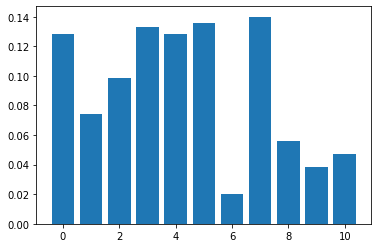

In [135]:
import matplotlib.pyplot as plt
# feature importance
print(xgbmodel.feature_importances_)
# plot
plt.bar(range(len(xgbmodel.feature_importances_)), xgbmodel.feature_importances_)
plt.show()

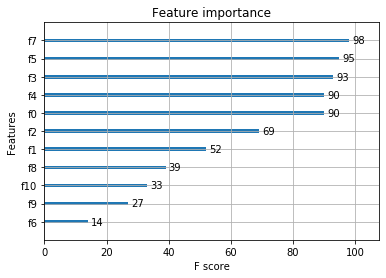

In [136]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgbmodel)
plt.show()

In [137]:
# Fit model using each importance as a threshold

from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
thresholds = sort(xgbmodel.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgbmodel, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(Y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.020, n=11, Accuracy: 78.37%
Thresh=0.039, n=10, Accuracy: 78.39%
Thresh=0.047, n=9, Accuracy: 78.23%
Thresh=0.056, n=8, Accuracy: 78.21%
Thresh=0.074, n=7, Accuracy: 78.22%
Thresh=0.099, n=6, Accuracy: 78.14%
Thresh=0.129, n=5, Accuracy: 78.08%
Thresh=0.129, n=5, Accuracy: 78.08%
Thresh=0.133, n=3, Accuracy: 76.70%
Thresh=0.136, n=2, Accuracy: 75.44%
Thresh=0.140, n=1, Accuracy: 75.43%


In [138]:
# n= 10 gives slight improvement in accuracy so building a model on that threshold

In [139]:
from xgboost import XGBClassifier
from sklearn import metrics
xgb= XGBClassifier(random_state = 1,scale_pos_weight=3.0, threshold = 0.037)
xgbmodel = xgb.fit(X_train, Y_train)
prediction_1 = xgbmodel.predict(X_train)

# Evaluate predictions
print(metrics.accuracy_score(Y_train, prediction_1))
print(metrics.confusion_matrix(Y_train, prediction_1))
print(metrics.classification_report(Y_train, prediction_1))

0.7142462804842117
[[548506 183419]
 [ 92980 142358]]
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80    731925
         1.0       0.44      0.60      0.51    235338

    accuracy                           0.71    967263
   macro avg       0.65      0.68      0.65    967263
weighted avg       0.75      0.71      0.73    967263



In [91]:
#evaluation using K-fold crossvalidation
# CV model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, random_state=1)
results = cross_val_score(xgbmodel, X_train, Y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Accuracy: 71.34% (0.15%)


In [141]:

probability = xgbmodel.predict_proba(X)
prediction_together = xgbmodel.predict(X)

# Evaluate predictions
print(metrics.accuracy_score(Y, prediction_together))
print(metrics.confusion_matrix(Y, prediction_together))
print(metrics.classification_report(Y, prediction_together))

0.7138903890480023
[[684820 229527]
 [116417 178367]]
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.80    914347
         1.0       0.44      0.61      0.51    294784

    accuracy                           0.71   1209131
   macro avg       0.65      0.68      0.65   1209131
weighted avg       0.75      0.71      0.73   1209131



In [142]:
prediction = prediction_together.tolist()
probabilities = probability.tolist()
data_1['prediction_buying'] = prediction
data_1['probability'] = probabilities

In [147]:
import numpy as np
dept = pd.read_csv("D:\TN\Capstone\Datasets\departments.csv")
products = pd.read_csv("D:\TN\Capstone\Datasets\products.csv",encoding="ISO-8859-1")
df = data_1.merge(products,on =('product_id'), how = ('left'))
df = df.merge(dept,on =('department_id'), how = ('left'))
df["true_vs_label"] = np.where(df['prediction_buying']==df['is_in_next_cart'],'Correct_prediction', 'Wrong_prediction')
print(df.keys())


Index(['user_id', 'product_id', 'user_days_since_prior_order', 'user_prod_purchase_frequency', 'avg_add_to_cart_order', 'userprod_order_count_60', 'userprod_in60_reorder_rate', 'avg_prod_count', 'predicted_purchase_interval', 'recency_userproduct', 'is_in_latest1_order', 'is_in_latest2_order', 'is_in_latest3_order', 'is_in_next_cart', 'prediction_buying', 'probability', 'product_name',
       'aisle_id', 'department_id', 'department', 'true_vs_label'],
      dtype='object')


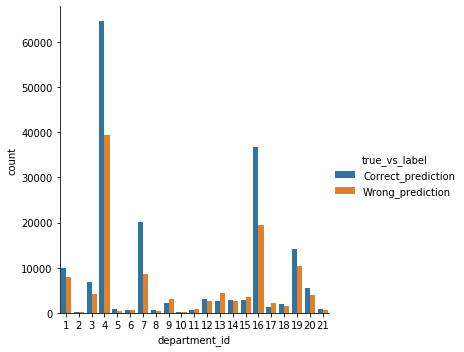

In [148]:
p1 = df[df['is_in_next_cart']==1]
plt_1 = p1.groupby(['department_id', 'true_vs_label']).size().reset_index(name="count")
import seaborn as sns
sns.catplot(x="department_id", y="count", hue="true_vs_label", kind="bar", data=plt_1);


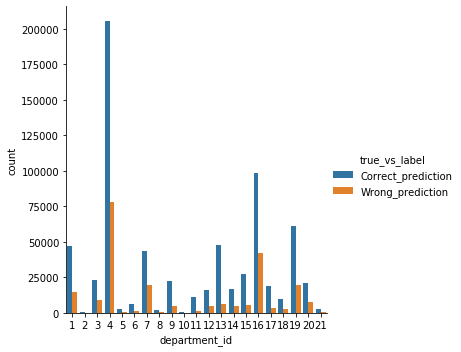

In [149]:
p2 = df[df['is_in_next_cart']==0]
plt_2 = p2.groupby(['department_id', 'true_vs_label']).size().reset_index(name="count")
import seaborn as sns
sns.catplot(x="department_id", y="count", hue="true_vs_label", kind="bar", data=plt_2);
